# Social Network

In [32]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
import plotly.graph_objects as go
import logging
import time
import matplotlib.animation as animation
import matplotlib.cm as cm  # For colormap
from matplotlib.colorbar import ColorbarBase

In [33]:
import os
import google.generativeai as genai
from IPython.display import Markdown
from google.generativeai.types import HarmCategory, HarmBlockThreshold

os.environ['GOOGLE_API_KEY'] = "-Ac9lCE"
genai.configure(api_key = os.environ['GOOGLE_API_KEY'])

chat_model = genai.GenerativeModel('gemini-pro')
generation_config = genai.types.GenerationConfig(
    candidate_count=1,
    stop_sequences=['.'],
    max_output_tokens=150,
    top_p = 1,
    top_k = 8,
    temperature=1
)
safety_settings = {
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
}

In [34]:
rc("animation", html="jshtml")

## Function Definitions


In [35]:
def cosine_similarity(post_atribute_distribution, agent_atribute_preference):
    all_atributes_items = set(agent_atribute_preference.keys()).union(set(post_atribute_distribution.keys()))

    # Create vectors from the dictionaries, ensuring missing topics are assigned a probability of 0
    agent_vector = np.array([agent_atribute_preference.get(atribute_item, 0) for atribute_item in all_atributes_items])
    post_vector = np.array([post_atribute_distribution.get(atribute_item, 0) for atribute_item in all_atributes_items])

    # Calculate the cosine similarity
    cosine_similarity = np.dot(agent_vector, post_vector) / (np.linalg.norm(agent_vector) * np.linalg.norm(post_vector))
    return cosine_similarity

In [36]:
def create_post(agent, topic_distribution, sentiment_distribution):
    thread = chat_model.start_chat(history=[])
    
    query_tweet = f"""
    You are a tweeter {agent.type}.
    I will provide a dictionary of items with probability distributions about the content of the output. 
    Create content tweet talking about about {topic_distribution} in a {sentiment_distribution} sentiment. 
    Be specific, do not create a general message.
    """
    
    tweet = thread.send_message(query_tweet,
                                generation_config=generation_config,
                                safety_settings=safety_settings)
    Markdown(tweet.text)
    time.sleep(2)

    return thread, tweet.text

In [37]:
def reply_tweet(post, agent, engagement_type):
    query_comment = f"""
    You are a tweeter {agent.type}. 
    Answer to the previous tweet with {engagement_type} engagement.
    """

    comment = post.thread.send_message(query_comment,
                                        generation_config=generation_config,
                                        safety_settings=safety_settings)
    Markdown(comment.text)
    time.sleep(2)

    return post.thread, comment.text

In [38]:
def response_to_reply(thread, agent):
    query_comment = f"""
    You are the creator of the tweet. 
    Answer the previous comment.
    """

    comment = chat.send_message(query_comment, generation_config=config)
    Markdown(comment.text)
    time.sleep(5)
    return thread

## Class definitions

In [39]:
class Post:
    def __init__(self, author, date, topic_distribution, sentiment_distribution):
        self.author = author
        self.date = date
        self.topic_distribution = topic_distribution
        self.sentiment_distribution = sentiment_distribution
        self.thread, self.text = create_post(author, topic_distribution, sentiment_distribution) #("", "tweet_text")
        logger.info(f"{self.author.agent_id} posted:\n {self.text} {self.topic_distribution} being {self.sentiment_distribution}\n")
        
    def __repr__(self):
        return f"{self.author}'s post"

In [40]:
class Agent:
    def __init__(self, agent_id, followers=None, topic_preference=None, sentiment_preference=None):
        self.agent_id = agent_id
        self.topic_preference = topic_preference if topic_preference else {}
        self.sentiment_preference = sentiment_preference if sentiment_preference else {}
        self.feed = {}
        self.post_history = []
    
    def __repr__(self):
        return self.agent_id
        
    def tweet(self, content):
        post = Post(author = self,
                    date = content["date"],
                    topic_distribution = content["topic_distribution"],
                    sentiment_distribution = content["sentiment_distribution"])
        self.post_history.append(post)
        return post
        
    def engage_with_post(self, post):#THIS SHOULD BE MORE OPTIMIZED.
        # Calculate engagement chance based on overlapping topics and probabilities
        cosine_similarities = []
        cosine_similarities.append(cosine_similarity(post.topic_distribution, self.topic_preference))
        cosine_similarities.append(cosine_similarity(post.sentiment_distribution, self.sentiment_preference))
        
        normalized_cosine_similarities = np.divide(cosine_similarities, len(cosine_similarities)) #this gives every atribute the same importance... not sure
        normalized_cosine_similarities_sum = sum(normalized_cosine_similarities)
        
        positive_engagement_chance = normalized_cosine_similarities_sum * self.engagement_rate
                
        negative_engagement_rate = 0.05 # negative, hate, ofensive... TO BE DEFINED! Probably per cluster
        negative_engagement_chance = (1-normalized_cosine_similarities_sum) * negative_engagement_rate
              
        if (random.random() < positive_engagement_chance):
            action = random.choices(["like", "retweet", "comment"], [0.4,0.4,0.2])[0] #Calibrate to real data!
            engagement_type = "positive"
            logger.info(f"{self.agent_id} {action}d post of date {post.date} by {post.author.agent_id} [et={engagement_type}, pec={round(positive_engagement_chance,2)}, cs={round(normalized_cosine_similarities_sum,2)}]\n")
            if action == 'comment':
                thread, text = reply_tweet(post, self, engagement_type)
                logger.info(f"{text}\n")
            return action, engagement_type
        elif (random.random() < negative_engagement_chance):
            action = random.choice(["comment"])
            engagement_type = "negative"
            logger.info(f"{self.agent_id} {action}d post of date {post.date} by {post.author.agent_id} [et={engagement_type}, nec={round(negative_engagement_chance,2)}, cs={round(normalized_cosine_similarities_sum,2)}]\n")
            if action == 'comment':
                thread, text = reply_tweet(post, self, engagement_type) 
                logger.info(f"{text}\n")
            return action, engagement_type
        return None, None


class Influencer(Agent):
    def __init__(self, agent_id, followers=None, topic_preference=None, sentiment_preference=None):
        super().__init__(agent_id, followers, topic_preference, sentiment_preference)
        self.type = 'Influencer'
        self.posting_frequency = 0.3
        self.engagement_rate = 0.5
        self.follow_rate = 1#0.1
        self.unfollow_rate = 0.1

class Sharer(Agent):
    def __init__(self, agent_id, followers=None, topic_preference=None, sentiment_preference=None):
        super().__init__(agent_id, followers, topic_preference, sentiment_preference)
        self.type = 'Sharer'
        self.posting_frequency = 0.1
        self.engagement_rate = 0.9
        self.follow_rate = 1#0.5
        self.unfollow_rate = 0.1

class StandardUser(Agent):
    def __init__(self, agent_id, followers=None, topic_preference=None, sentiment_preference=None):
        super().__init__(agent_id, followers, topic_preference, sentiment_preference)
        self.type = 'StandardUser'
        self.posting_frequency = 0.1
        self.engagement_rate = 0.5
        self.follow_rate = 1#0.2
        self.unfollow_rate = 0.1

In [46]:
class SocialNetwork:
    def __init__(self):
        self.follow_graph = nx.DiGraph()
        self.interaction_graph = nx.DiGraph()
        
    def add_agent(self, agent):
        self.follow_graph.add_node(agent, type=agent.type)
        self.interaction_graph.add_node(agent, type=agent.type) 

    def create_followers(self, agent, followers):
        for follower in followers:    
            self.follow_graph.add_edge(follower, agent, action='follow')
                 
    def scroll(self, agent, date):
        for post, post_data in agent.feed.copy().items():
            author = post.author
            sharer = post_data["sharer"]
            date = post_data["date"]
            
            # Avoid engagement with own posts
            if (agent.agent_id != author.agent_id):
                action, engagement_type = agent.engage_with_post(post)
                if action:
                    self.interaction_graph.add_edge(agent, post, action=action)
                    if action == 'retweet':
                        self.propagate_post(agent, post, date)
                    
                    if ((engagement_type == "positive") and 
                        (random.random() < agent.follow_rate) and 
                        (agent not in self.follow_graph.predecessors(author))):
                        self.follow_graph.add_edge(agent, author)
                        logger.info(f"    {agent} started following {author} :)\n")
                        
                    elif ((engagement_type=="negative") and 
                          (random.random() < agent.unfollow_rate)): #Right now comments the author and unfollows the writer. Interaction to be better defined. (twitter knowledge: can you comment a retweet? would you unfollow both in this case? etc.)
                        self.follow_graph.remove_edge(agent, sharer)
                        logger.info(f"    {agent} stopped following {sharer} :(\n")
            agent.feed.pop(post)
    
    def propagate_post(self, agent, post, date):
        for follower in self.follow_graph.predecessors(agent):
            follower.feed[post] = {'sharer': agent, 'date': date}
            
    def update(self, step):
        date = step
        for agent in self.follow_graph.nodes:
            if random.random() < agent.posting_frequency:
                content = {
                    "date": date,
                    "topic_distribution": agent.topic_preference,
                    "sentiment_distribution": agent.sentiment_preference,
                    # To do: modify a bit preferneces form post to post. Not all post should follow strictly the authors preferences.
                }
                post = agent.tweet(content)
                self.interaction_graph.add_node(post, type='Post')
                self.propagate_post(agent, post, date)
            self.scroll(agent, date)
    
    def run_animation(self, n_steps):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_xticks([])
        ax2.set_yticks([])

        # Use spring layout for consistent positioning
        pos_follow = nx.spring_layout(self.follow_graph)
        pos_interaction = nx.spring_layout(self.interaction_graph)
        
        # Create color bars outside the visualize function
        norm_follow = plt.Normalize(0, 1)  # Temporary normalization (will update dynamically)
        sm_follow = cm.ScalarMappable(cmap=cm.viridis, norm=norm_follow)
        cbar_follow = fig.colorbar(sm_follow, ax=ax1, orientation='vertical', label='Num. Followers')

        norm_interaction = plt.Normalize(0, 1)  # Temporary normalization (will update dynamically)
        sm_interaction = cm.ScalarMappable(cmap=cm.plasma, norm=norm_interaction)
        cbar_interaction = fig.colorbar(sm_interaction, ax=ax2, orientation='vertical', label='Num. Interactions')

        def visualize_network(step):
            logger.info("\n\n")
            logger.info(f"######### STEP {step} #########\n")

            ax1.clear()
            ax2.clear()

            # In-Degree-based color for follow_graph
            if isinstance(self.follow_graph, nx.DiGraph):
                degrees_follow = dict(self.follow_graph.in_degree())
            else:
                degrees_follow = dict(self.follow_graph.degree())  # Fallback for undirected graphs

            max_degree_follow = max(degrees_follow.values()) if degrees_follow else 1
            norm_follow.vmin, norm_follow.vmax = 0, max_degree_follow  # Update normalization dynamically
            colors_follow = [cm.viridis(norm_follow(degrees_follow[node])) for node in self.follow_graph.nodes]

            nx.draw_networkx(
                self.follow_graph, pos_follow, ax=ax1, 
                node_color=colors_follow, with_labels=True
            )
            ax1.set_title(f'Follow Network at Step {step}')

            # In-Degree-based color for interaction_graph
            if isinstance(self.interaction_graph, nx.DiGraph):
                degrees_interaction = dict(self.interaction_graph.in_degree())
            else:
                degrees_interaction = dict(self.interaction_graph.degree())  # Fallback for undirected graphs

            max_degree_interaction = max(degrees_interaction.values()) if degrees_interaction else 1
            norm_interaction.vmin, norm_interaction.vmax = 0, max_degree_interaction  # Update normalization dynamically
            colors_interaction = [cm.plasma(norm_interaction(degrees_interaction[node])) for node in self.interaction_graph.nodes]
            
            pos_interaction.update(
                nx.spring_layout(self.interaction_graph, pos=pos_interaction, fixed=pos_interaction.keys(), scale=0, k=0.1)
            )
            
            nx.draw_networkx(
                self.interaction_graph, pos_interaction, ax=ax2, 
                node_color=colors_interaction, with_labels=True
            )
            ax2.set_title(f'Interaction Network at Step {step}')

            # Update the network for the current step
            self.update(step)

            # Update color bar limits (optional, in case of drastic degree changes)
            sm_follow.set_norm(norm_follow)
            sm_interaction.set_norm(norm_interaction)

        return animation.FuncAnimation(fig, visualize_network, frames=n_steps, interval=1500, repeat=True)

## A simple example

In [47]:
network = SocialNetwork()

# Influencers
influencer1 = Influencer(
    "Haoyuan", 
    topic_preference={"tech": 0.7, "politics": 0.3},
    sentiment_preference={"negative": 0.2, "neutral": 0.3, "positive": 0.5}
)

influencer2 = Influencer(
    "Lily", 
    topic_preference={"lifestyle": 0.8, "fitness": 0.2},
    sentiment_preference={"negative": 0.1, "neutral": 0.4, "positive": 0.5}
)

# Sharers
sharer1 = Sharer(
    "Josep", 
    topic_preference={"lifestyle": 1.0},
    sentiment_preference={"negative": 0.1, "neutral": 0.5, "positive": 0.3}
)

sharer2 = Sharer(
    "Mia", 
    topic_preference={"lifestyle": 0.7, "fitness": 0.3},
    sentiment_preference={"negative": 0.1, "neutral": 0.5, "positive": 0.5}
)

# Standard Users
standard_user1 = StandardUser(
    "Andreu", 
    topic_preference={"lifestyle": 1.0},
    sentiment_preference={"negative": 0.3, "neutral": 0.3, "positive": 0.4}
)

standard_user2 = StandardUser(
    "Maria", 
    topic_preference={"science": 0.6, "politics": 0.4},
    sentiment_preference={"negative": 0.25, "neutral": 0.5, "positive": 0.25}
)

standard_user3 = StandardUser(
    "Tom", 
    topic_preference={"tech": 0.5, "travel": 0.5},
    sentiment_preference={"negative": 0.2, "neutral": 0.3, "positive": 0.5}
)

# Register agents in the network
network.add_agent(influencer1)
network.add_agent(influencer2)
network.add_agent(sharer1)
network.add_agent(sharer2)
network.add_agent(standard_user1)
network.add_agent(standard_user2)
network.add_agent(standard_user3)

# Create follower relationships
network.create_followers(influencer1, [sharer1, standard_user1, standard_user2, standard_user3])
network.create_followers(influencer2, [sharer2, standard_user1, standard_user3])

network.create_followers(sharer1, [sharer2])
network.create_followers(sharer2, [sharer1, standard_user1])

network.create_followers(standard_user1, [])
network.create_followers(standard_user2, [sharer2])
network.create_followers(standard_user3, [influencer2])

In [48]:
logger = logging.getLogger()
if logger.hasHandlers():
    logger.handlers.clear()
fhandler = logging.FileHandler(filename='app.log', mode='w')
formatter = logging.Formatter('%(asctime)s %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

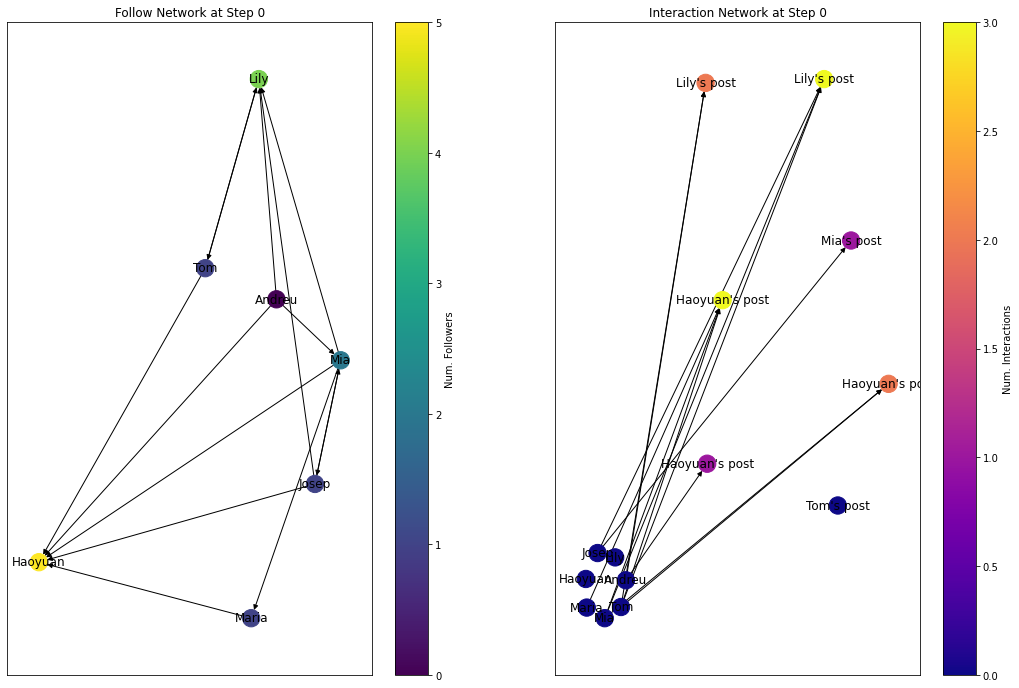

In [49]:
network.run_animation(10)

**Print log** Note. Steps are (n-1) the animation!

In [52]:
with open("app.log", 'r') as f:
    print(f.read())

2024-11-27 17:56:31,259 ######### STEP 0 #########


2024-11-27 17:56:31,331 ######### STEP 0 #########


2024-11-27 17:56:31,637 ######### STEP 1 #########


2024-11-27 17:56:31,926 ######### STEP 2 #########

2024-11-27 17:56:36,469 Haoyuan posted:
 Hey fam! Wanted to give my two cents on the latest tech/politics debacle {'tech': 0.7, 'politics': 0.3} being {'negative': 0.2, 'neutral': 0.3, 'positive': 0.5}

2024-11-27 17:56:36,469 Andreu retweetd post of date 2 by Haoyuan [et=positive, pec=0.24, cs=0.49]


2024-11-27 17:56:36,687 ######### STEP 3 #########


2024-11-27 17:56:40,273 Haoyuan posted:
 I'm shocked at the recent news about [Insert Topic] {'tech': 0.7, 'politics': 0.3} being {'negative': 0.2, 'neutral': 0.3, 'positive': 0.5}

2024-11-27 17:56:40,273 Maria retweetd post of date 3 by Haoyuan [et=positive, pec=0.27, cs=0.54]

2024-11-27 17:56:40,273 Tom commentd post of date 3 by Haoyuan [et=positive, pec=0.41, cs=0.82]
I agree! It's so frustrating to see how [Issue] is bein

### Notes for the future

- Obviously calibrate model with real data.

- (DONE) Add negative actions such as unfollow.
- Define better when negative actions occurr. Is it good doing the (1-ncs)?
- (DONE) Add action comment.
- (DONE) Work with probabilities, a post should have multiple topics. cosine similarity.
- (DONE) Add sentiment preferences.
- (DONE) Make posts an object? and keep track that one can not like a post twice.
- Add other atributes.
- In general check again for possible infinite loops due to recursiveness.
- The way agents interact will be way more complex.
- Random choices could be substituted by reinforcement learning. Parameters to be modified will be the probabilities of the atributes and the rewards are likes and follows. Might converge or not, also no idea what I would expect to want.
- Atributes should have a temporal component?. Everything should have a temporal component? How would you do this?
- (ONGOING) Create feed.
    Feed is a list from the agent class.
    Every step an agent goes through the feed.
    Agents add posts to the followers feed.
    Posts should last x days in the feed.
    Posts should disapear from the feed if seen from the user. (how do you do multiple comments in same post?)
    Everyday an agent will see a random number of posts (can be 0)
- Change the way feed works. Retrieve from a set of posts?
- We will need to include a simple algorithm to recommend outside your network based on trending posts. Kind of an ´explore´. Also to sort your content feed.
- Include slacks and biases, not everything should be perfect.
- Periodical addition of new users.
- Consider Transfer between agent classes: Influencer canceled of standard becoming popular.
- (DONE) Create animation/better visualization of results. Color edges when something happens!
- (DONE) Redirect output to log files.
- (DONE) Diferent graphs for followers and for engagements.
- Database of tweets, use a more scalable datastructure.